In [7]:
import numpy as np
from numba import njit
import scipy.optimize as opt
import scipy.linalg as linalg
import matplotlib.pyplot as plt

import mathutils
import het_block as het
import rec_block as rec
from rec_block import recursive
import jacobian as jac
import ks

In [8]:
def backward_iterate(Va_p, Pi_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (S*A), marginal value of assets tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    r        : scalar, ex-post interest rate
    w        : scalar, wage
    beta     : scalar, discount rate today
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    uc_nextgrid = (beta * Pi_p) @ Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = mathutils.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    mathutils.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

In [9]:
def pol_ss(Pi, e_grid, a_grid, r, w, beta, eis, Va_seed=None, tol=1E-8, maxit=5000):
    """Find steady-state policy functions."""
    if Va_seed is None:
        coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
        Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    else:
        Va = Va_seed

    # iterate until convergence of a policy by tol, or reach max number of iterations
    a = np.empty_like(Va)
    for it in range(maxit):
        Va, anew, c = backward_iterate(Va, Pi, a_grid, e_grid, r, w, beta, eis)

        if it % 10 == 1 and mathutils.within_tolerance(a, anew, tol):
            break
        a = anew
    else:
        raise ValueError(f'No convergence after {maxit} backward iterations!')
    a = anew

    return Va, a, c

In [10]:
def household_ss(Pi, a_grid, e_grid, r, w, beta, eis, Va_seed=None, D_seed=None, pi_seed=None):
    """Solve for steady-state policies and distribution. Report results in dict."""
    # solve ha block
    Va, a, c = pol_ss(Pi, e_grid, a_grid, r, w, beta, eis, Va_seed)
    D = mathutils.dist_ss(a, Pi, a_grid, D_seed, pi_seed)

    # return dictionary with results and inputs
    inputs = {'Pi': Pi, 'a_grid': a_grid, 'e_grid': e_grid, 'r': r, 'w': w, 'beta': beta, 'eis': eis}
    results = {'D': D, 'Va': Va, 'a': a, 'c': c, 'A': np.vdot(D, a), 'C': np.vdot(D, c)}

    return {**inputs, **results}

In [11]:
def ks_ss(lb=0.98, ub=0.999, r=0.01, eis=1, delta=0.025, alpha=0.11, b=0.15, pUE=0.5, pEU=0.038, nA=100, amax=20):
    """Solve steady state of full GE model. Calibrate beta to hit target for interest rate."""
    # set up grid
    a_grid = mathutils.agrid(amax=amax, n=nA)
    L = pUE / (pUE + pEU)  # labor endowment normalized to 1
    e_grid = np.array([b, 1 - (1 - L) / L * b])
    Pi = np.array([[1 - pUE, pUE], [pEU, 1 - pEU]])

    # solve for aggregates analitically
    rk = r + delta
    Z = (rk / alpha) ** alpha / L ** (1 - alpha)  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha)) * L
    Y = Z * K ** alpha * L ** (1 - alpha)
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))

    # solve for beta consistent with this
    beta_min = lb / (1 + r)
    beta_max = ub / (1 + r)
    beta, results = opt.brentq(lambda bet:
                               household_ss(Pi, a_grid, e_grid, r, w, bet, eis)['A'] - K,
                               beta_min, beta_max, full_output=True)
    if not results.converged:
        raise ValueError('Steady-state solver did not converge.')

    # extra evaluation to report variables
    ss = household_ss(Pi, a_grid, e_grid, r, w, beta, eis)
    mpc = mathutils.mpcs(ss['c'], ss['a_grid'], ss['r'])
    ss.update({'mpc': mpc, 'MPC': np.vdot(ss['D'], mpc),
               'w': w, 'Z': Z, 'K': K, 'L': L, 'Y': Y, 'alpha': alpha, 'delta': delta,
               'goods_mkt': Y - ss['C'] - delta * K})

    return ss

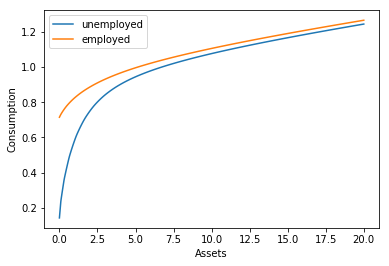

In [13]:
ss = ks_ss()
plt.plot(ss['a_grid'], ss['c'][0,:], label='unemployed')
plt.plot(ss['a_grid'], ss['c'][1,:], label='employed')
plt.legend()
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()